In [121]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, PoissonRegressor, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, accuracy_score, mean_poisson_deviance
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import scipy.stats as stats
from sklearn.utils.class_weight import compute_sample_weight

Предварительные сведения:
1. **Обычная линейная регрессия** использует предположение, что
переменные с предикторами связаны линейно, а остатки (ошибки
модели) имеют нормальное распределение и одинаковую дисперсию
всюду.
2. **Логистическая регрессия** использует в качестве базиса линейную
модель, и делает предсказание логарифма шансов (отношения
вероятности события к вероятности противоположного события) для
класса 1. Ошибки модели моделируются через распределение
Бернулли – то есть, ошибки в классе соответствуют тому, что целевая
переменная может случайно менять значение с 1 на 0 и наоборот.
3. **Пуассоновская регрессия** использует в качестве базиса линейную
модель, и делает предсказание для частоты событий – параметра
распределения Пуассона. Ошибка для данной модели базируется не на
нормальном распределении, а на распределении Пуассона. Обычно
используется для моделирования связи между предикторами и
целевой переменной-счётчиком.
4. **Для оценки качества** модели обычно используют следующие метрики:
    a. MSE – среднеквадратическое отклонение
    b. MAE – среднее абсолютное отклонение
    c. R-squared – процент объяснённой дисперсии
    d. Accuracy – точность классификации
    e. F1-score – среднее гармоническое между точностью (precision) и
    полнотой (recall).

В задачах ниже вам нужно будет провести предварительный анализ
признаков, подобрать подходящую линейную модель и метод
регуляризации для неё (при необходимости), обучить её и
проинтерпретировать результаты. Свой выбор необходимо будет вкратце
обосновать (помните – на практике точного и полного выполнения всех
предположений какой-либо модели ожидать не стоит,
Можно использовать готовые функции из пакетов.

### **Задача 1**
Постройте модели для предсказания оценок студентов – по одной
модели на каждую оценку из G1, G2 и G3. Результаты по каждой из моделей
проинтерпретируйте и сравните.
Датасет для задачи: students_regression.xlsx

**РЕШЕНИЕ**

**Выбранная модель**: Линейная регрессия, т.к. оценки являются числовыми величинами в определенном диапазоне. Пуассоновская регрессия не подходит, т.к. оценки — не счетные данные. Логистическая регрессия не подходит, т.к. нет бинарной целевой переменной.

In [2]:
df = pd.read_csv("students_regression.csv", sep=';')
print(df.shape)
df.head()

(395, 33)


school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]

In [3]:
df.describe()

age        Medu        Fedu  traveltime   studytime    failures  \
count  395.000000  395.000000  395.000000  395.000000  395.000000  395.000000   
mean    16.696203    2.749367    2.521519    1.448101    2.035443    0.334177   
std      1.276043    1.094735    1.088201    0.697505    0.839240    0.743651   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    2.000000    1.000000    1.000000    0.000000   
50%     17.000000    3.000000    2.000000    1.000000    2.000000    0.000000   
75%     18.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     22.000000    4.000000    4.000000    4.000000    4.000000    3.000000   

           famrel    freetime       goout        Dalc        Walc      health  \
count  395.000000  395.000000  395.000000  395.000000  395.000000  395.000000   
mean     3.944304    3.235443    3.108861    1.481013    2.291139    3.554430   
std      0.896659    0.998862    1.113278    0.890741    1.287897    1.390303   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      4.000000    3.000000    2.000000    1.000000    1.000000    3.000000   
50%      4.000000    3.000000    3.000000    1.000000    2.000000    4.000000   
75%      5.000000    4.000000    4.000000    2.000000    3.000000    5.000000   
max      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

         absences          G1          G2          G3  
count  395.000000  395.000000  395.000000  395.000000  
mean     5.708861   10.908861   10.713924   10.415190  
std      8.003096    3.319195    3.761505    4.581443  
min      0.000000    3.000000    0.000000    0.000000  
25%      0.000000    8.000000    9.000000    8.000000  
50%      4.000000   11.000000   11.000000   11.000000  
75%      8.000000   13.000000   13.000000   14.000000  
max     75.000000   19.000000   19.000000   20.000000

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [5]:
df.nunique()

school         2
sex            2
age            8
address        2
famsize        2
Pstatus        2
Medu           5
Fedu           5
Mjob           5
Fjob           5
reason         4
guardian       3
traveltime     4
studytime      4
failures       4
schoolsup      2
famsup         2
paid           2
activities     2
nursery        2
higher         2
internet       2
romantic       2
famrel         5
freetime       5
goout          5
Dalc           5
Walc           5
health         5
absences      34
G1            17
G2            17
G3            18
dtype: int64

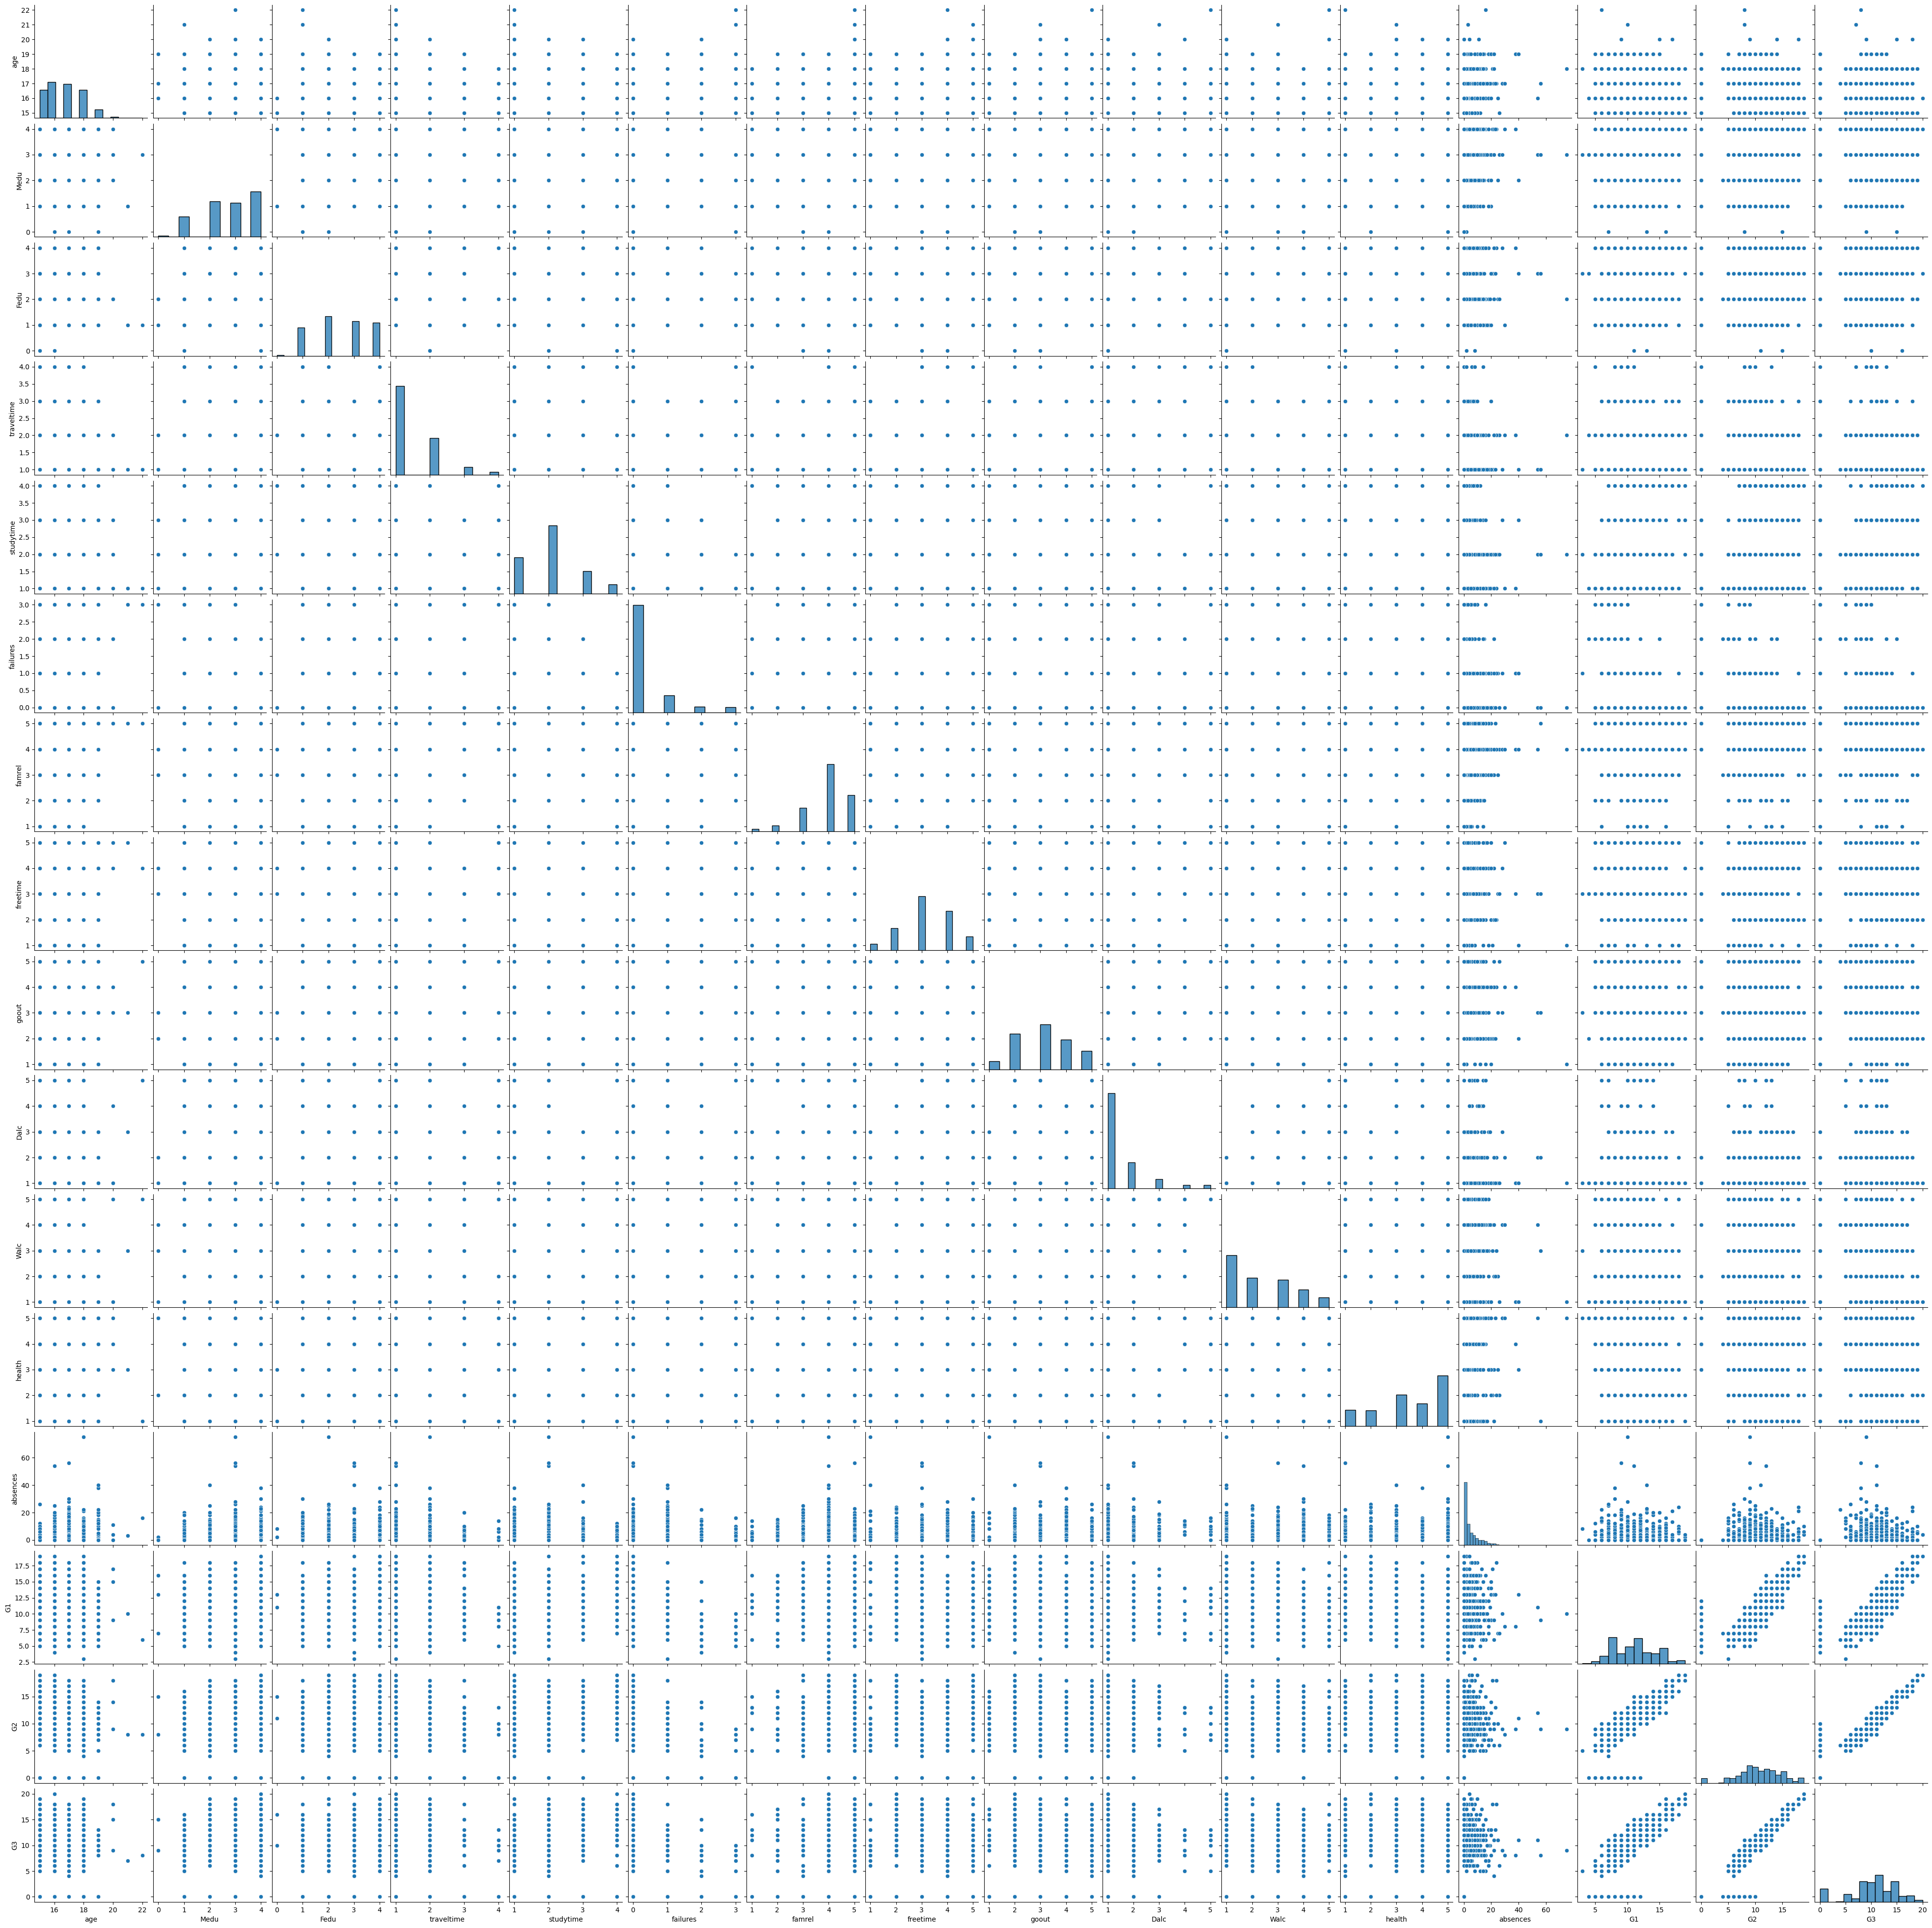

In [6]:
sns.pairplot(df)

#### Из графика видно, что мы вряд ли сможем построить хорошую линейную модель для данного датасета, т.к. линейно зависимы в основном только оценки между друг другом, которые нужно исключить при анализе датасета для каждой оценки для корректности выполнения задания.

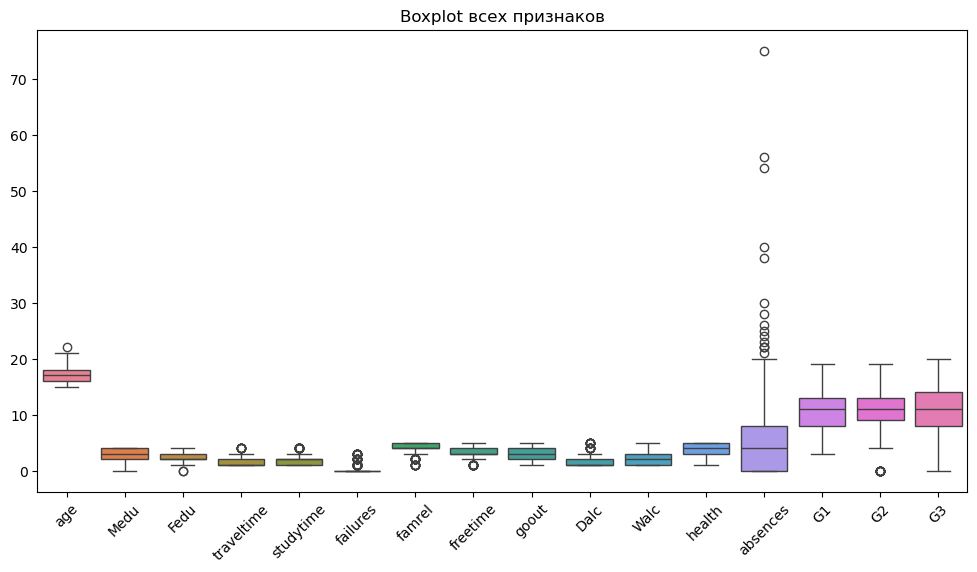

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=45) 
plt.title('Boxplot всех признаков')
plt.show()

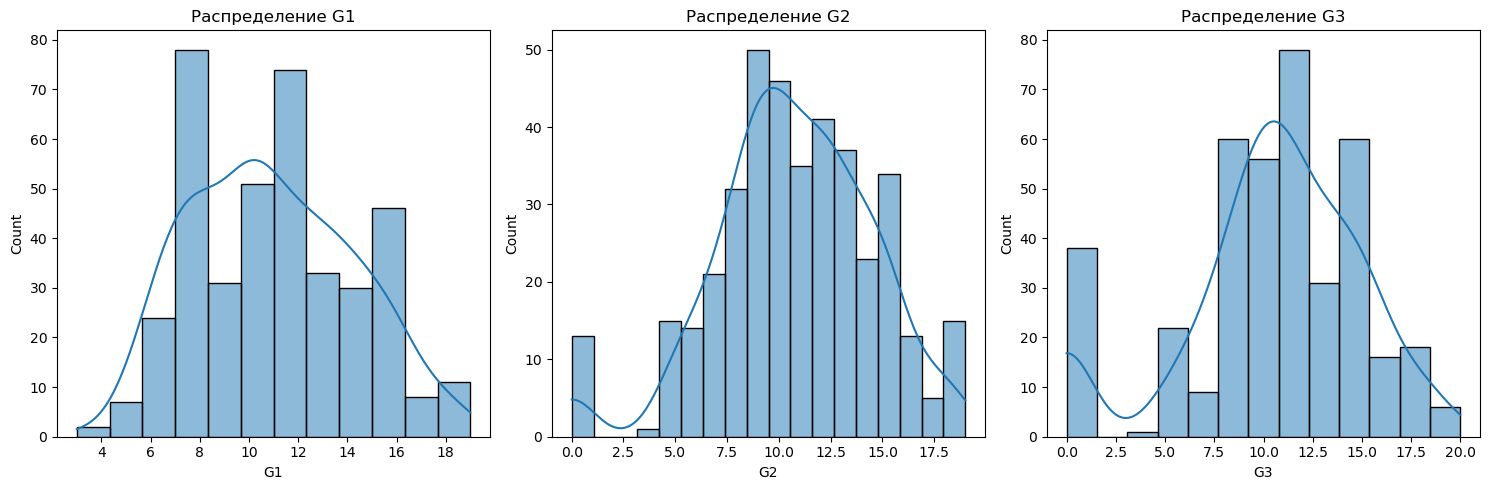

In [8]:
plt.figure(figsize=(15, 5))
for i , col in enumerate(['G1', 'G2', 'G3'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

In [9]:
X = df.drop(columns=['G1', 'G2', 'G3'])
X.shape

(395, 30)

In [11]:
cat_features = ['school',	'sex',	'address',	'famsize',	'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid',
               'activities', 'nursery', 'higher', 'internet', 'romantic']
num_features = ['age', 'Medu',	'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime',	'goout',	'Dalc',	'Walc',	'health',	'absences']

In [12]:
# удаление выбросов
mask = pd.Series(True, index=df.index)

def delete_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    data[column] =  data[column].clip(lower_bound, upper_bound)

In [13]:
def calculate_vif(X):
    X = X.loc[:, X.nunique() > 1] 
    X_const = add_constant(X)
    vif = pd.DataFrame()
    vif['feature'] = X_const.columns
    vif['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
    return vif

In [14]:
# устранение мультиколлинеарности
def remove_high_vif_features(X_train, X_test, threshold=10):
    X_train_clean = X_train.copy()
    X_test_clean = X_test.copy()
    
    while True:
        vif_res = calculate_vif(X_train_clean) 
        vif_res = vif_res[vif_res['feature'] != 'const']
        if vif_res.empty or vif_res['VIF'].max() < threshold:
            break
        worst_feature = vif_res.loc[vif_res['VIF'].idxmax(), 'feature']
        X_train_clean = X_train_clean.drop(columns=[worst_feature])
        X_test_clean = X_test_clean.drop(columns=[worst_feature])
    return X_train_clean, X_test_clean

In [15]:
# обучение и оценка модели
def train_and_evaluate(model, params, X_train, X_test, y_train, y_test):
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=params, 
        scoring='neg_mean_squared_error', 
        cv=5, 
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, rmse, r2, grid_search.best_params_, best_model, y_pred

In [16]:
models = {
    'OLS': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1, 10]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1, 10]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1, 10],
            'l1_ratio': [0.2, 0.5, 0.8]
        }
    }
}

## Модель для G1

In [17]:
target = 'G1'

In [18]:
y = df[target]
y = pd.DataFrame({'G1': y})
y.head()

G1
0   5
1   5
2   7
3  15
4   6

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [20]:
X_train.nunique()

school         2
sex            2
age            8
address        2
famsize        2
Pstatus        2
Medu           5
Fedu           5
Mjob           5
Fjob           5
reason         4
guardian       3
traveltime     4
studytime      4
failures       4
schoolsup      2
famsup         2
paid           2
activities     2
nursery        2
higher         2
internet       2
romantic       2
famrel         5
freetime       5
goout          5
Dalc           5
Walc           5
health         5
absences      33
dtype: int64

In [21]:
preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_features),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='first'), cat_features),
        ]
    )
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
cat_encoder = preprocessor.named_transformers_["cat"]
cat_feature_names = cat_encoder.get_feature_names_out(cat_features)

all_feature_names = num_features + list(cat_feature_names)

X_train = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_test = pd.DataFrame(X_test_processed, columns=all_feature_names)
print(f'X_train shape: {X_train.shape}')

X_train shape: (316, 39)


In [25]:
# удаление выбросов
for column in X_train[num_features].columns:
    if X_train[column].nunique() > 2:
        delete_outliers(X_train, column)

delete_outliers(y_train, target)

In [26]:
# устранение мультиколлинеарности
X_train, X_test = remove_high_vif_features(X_train, X_test)
final_vif = calculate_vif(X_train)
final_vif['VIF'].max()
print(final_vif.sort_values('VIF', ascending=False))

              feature        VIF
0               const  81.726990
23         Fjob_other   5.482880
24      Fjob_services   4.851513
21       Mjob_teacher   3.097364
2                Medu   2.924852
20      Mjob_services   2.680528
19         Mjob_other   2.554941
10               Walc   2.531391
25       Fjob_teacher   2.487460
18        Mjob_health   2.344174
22        Fjob_health   2.153923
9                Dalc   2.104319
3                Fedu   2.039631
1                 age   1.782922
30     guardian_other   1.717095
8               goout   1.622245
14              sex_M   1.566688
28  reason_reputation   1.560977
29    guardian_mother   1.559009
5           studytime   1.456677
13          school_MS   1.439103
26        reason_home   1.438091
33           paid_yes   1.371127
27       reason_other   1.356275
7            freetime   1.340887
4          traveltime   1.337824
15          address_U   1.328389
12           absences   1.327436
32         famsup_yes   1.324721
36        

In [27]:
target_res = {}
y_train = y_train.squeeze()
y_test = y_test.squeeze()
for model, config in models.items():
    mse, mae, rmse, r2, best_params, best_model, y_pred = train_and_evaluate(config['model'], config['params'], X_train, X_test, y_train, y_test)
    target_res[model] = {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "Best_params": best_params,
        "Y_pred": y_pred
    }

In [28]:
print(f"\n=== Результаты для {target} ===")
for model_name, metrics in target_res.items():
    print(f"\n{model_name}:")
    print(f"  MAE = {metrics['MAE']:.2f}")
    print(f"  MSE = {metrics['MSE']:.2f}")
    print(f"  RMSE = {metrics['RMSE']:.2f}")
    print(f"  R2 = {metrics['R2']:.2f}")
    if metrics["Best_params"]:
        print(f"  Лучшие параметры: {metrics['Best_params']}")
    


=== Результаты для G1 ===

OLS:
  MAE = 2.98
  MSE = 11.86
  RMSE = 3.44
  R2 = 0.13

Ridge:
  MAE = 2.95
  MSE = 11.56
  RMSE = 3.40
  R2 = 0.15
  Лучшие параметры: {'alpha': 10}

Lasso:
  MAE = 2.97
  MSE = 12.28
  RMSE = 3.50
  R2 = 0.10
  Лучшие параметры: {'alpha': 0.1}

ElasticNet:
  MAE = 2.94
  MSE = 11.85
  RMSE = 3.44
  R2 = 0.13
  Лучшие параметры: {'alpha': 0.1, 'l1_ratio': 0.5}


In [29]:
best_pred = target_res['Ridge']['Y_pred']

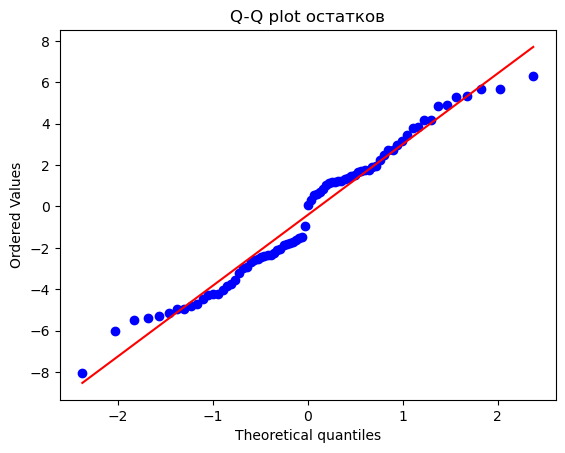

In [30]:
# Q-Q plot остатков
residuals = y_test - best_pred
stats.probplot(residuals, plot=plt)
plt.title('Q-Q plot остатков')
plt.show()

In [31]:
# Тест Шапиро-Уилка
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {shapiro_test.pvalue:.2f}")

Shapiro-Wilk test p-value: 0.06


<Axes: >

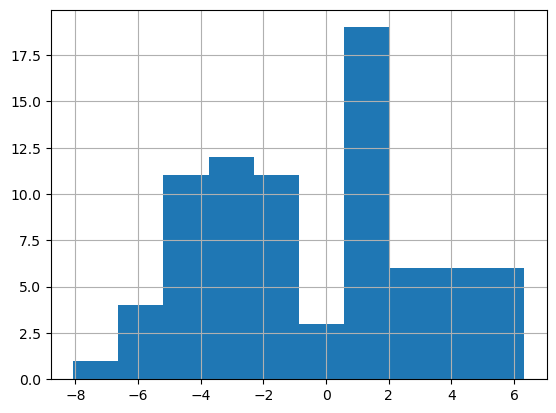

In [32]:
(y_test - best_pred).hist()

#### => Предпосылки линейной регрессии скорее выполняются 

### **Лучшая модель для G1 - Ridge**:
- MAE = 2.95
- MSE = 11.56
- RMSE = 3.40
- R2 = 0.15
- Лучшие параметры: {'alpha': 10}

In [33]:
best_model_coef = pd.DataFrame({
    'feature': X_train.columns,
    'coef': best_model.coef_
})

important_features = best_model_coef[best_model_coef['coef'] != 0].sort_values(by="coef", ascending=False)
print("Коэффициенты")
print(important_features)

Коэффициенты
              feature      coef
36         higher_yes  0.736166
4           studytime  0.616364
14              sex_M  0.425364
1                Medu  0.356624
16        famsize_LE3  0.322959
2                Fedu  0.320551
18        Mjob_health  0.271787
20      Mjob_services  0.210264
28  reason_reputation  0.179495
7            freetime  0.170100
25       Fjob_teacher  0.150675
33           paid_yes  0.071616
37       internet_yes  0.048690
12           absences  0.034541
6              famrel  0.012540
0                 age -0.006103
9                Dalc -0.079713
10               Walc -0.088121
11             health -0.119608
19         Mjob_other -0.132653
23         Fjob_other -0.161044
8               goout -0.408429
32         famsup_yes -0.624307
31      schoolsup_yes -1.184254


**Топ-3 позитивных фактора для G1:**
- Планы на вуз (+0.74 балла)
- Время на учёбу (+0.62)
- Мужской пол (+0.43)

**Топ-3 негативных фактора**:
- Школьная помощь (-1.18)
- Семейная поддержка (-0.62)
- Активная соцжизнь (-0.41)

## Модель для G2

In [34]:
target = 'G2'

In [35]:
y = df[target]
y = pd.DataFrame({'G2': y})
y.head()

G2
0   6
1   5
2   8
3  14
4  10

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [37]:
X_train.nunique()

school         2
sex            2
age            8
address        2
famsize        2
Pstatus        2
Medu           5
Fedu           5
Mjob           5
Fjob           5
reason         4
guardian       3
traveltime     4
studytime      4
failures       4
schoolsup      2
famsup         2
paid           2
activities     2
nursery        2
higher         2
internet       2
romantic       2
famrel         5
freetime       5
goout          5
Dalc           5
Walc           5
health         5
absences      33
dtype: int64

In [38]:
preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_features),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='first'), cat_features),
        ]
    )
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
cat_encoder = preprocessor.named_transformers_["cat"]
cat_feature_names = cat_encoder.get_feature_names_out(cat_features)

all_feature_names = num_features + list(cat_feature_names)

X_train = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_test = pd.DataFrame(X_test_processed, columns=all_feature_names)
print(f'X_train shape: {X_train.shape}')

X_train shape: (316, 39)


In [39]:
for column in X_train[num_features].columns:
    if X_train[column].nunique() > 2:
        delete_outliers(X_train, column)

delete_outliers(y_train, target)

In [40]:
X_train, X_test = remove_high_vif_features(X_train, X_test, 8)
final_vif = calculate_vif(X_train)
final_vif['VIF'].max()
print(final_vif.sort_values('VIF', ascending=False))

              feature        VIF
0               const  81.726990
23         Fjob_other   5.482880
24      Fjob_services   4.851513
21       Mjob_teacher   3.097364
2                Medu   2.924852
20      Mjob_services   2.680528
19         Mjob_other   2.554941
10               Walc   2.531391
25       Fjob_teacher   2.487460
18        Mjob_health   2.344174
22        Fjob_health   2.153923
9                Dalc   2.104319
3                Fedu   2.039631
1                 age   1.782922
30     guardian_other   1.717095
8               goout   1.622245
14              sex_M   1.566688
28  reason_reputation   1.560977
29    guardian_mother   1.559009
5           studytime   1.456677
13          school_MS   1.439103
26        reason_home   1.438091
33           paid_yes   1.371127
27       reason_other   1.356275
7            freetime   1.340887
4          traveltime   1.337824
15          address_U   1.328389
12           absences   1.327436
32         famsup_yes   1.324721
36        

In [41]:
target_res = {}
y_train = y_train.squeeze()
y_test = y_test.squeeze()
for model, config in models.items():
    mse, mae, rmse, r2, best_params, best_model, y_pred = train_and_evaluate(config['model'], config['params'], X_train, X_test, y_train, y_test)
    target_res[model] = {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "Best_params": best_params,
        "Y_pred": y_pred
    }

In [42]:
print(f"\n=== Результаты для {target} ===")
for model_name, metrics in target_res.items():
    print(f"\n{model_name}:")
    print(f"  MAE = {metrics['MAE']:.2f}")
    print(f"  MSE = {metrics['MSE']:.2f}")
    print(f"  RMSE = {metrics['RMSE']:.2f}")
    print(f"  R2 = {metrics['R2']:.2f}")
    if metrics["Best_params"]:
        print(f"  Лучшие параметры: {metrics['Best_params']}")
    


=== Результаты для G2 ===

OLS:
  MAE = 2.82
  MSE = 11.61
  RMSE = 3.41
  R2 = 0.18

Ridge:
  MAE = 2.83
  MSE = 11.50
  RMSE = 3.39
  R2 = 0.19
  Лучшие параметры: {'alpha': 10}

Lasso:
  MAE = 2.95
  MSE = 12.30
  RMSE = 3.51
  R2 = 0.14
  Лучшие параметры: {'alpha': 0.1}

ElasticNet:
  MAE = 2.89
  MSE = 11.84
  RMSE = 3.44
  R2 = 0.17
  Лучшие параметры: {'alpha': 0.1, 'l1_ratio': 0.5}


In [43]:
best_pred = target_res['Ridge']['Y_pred']

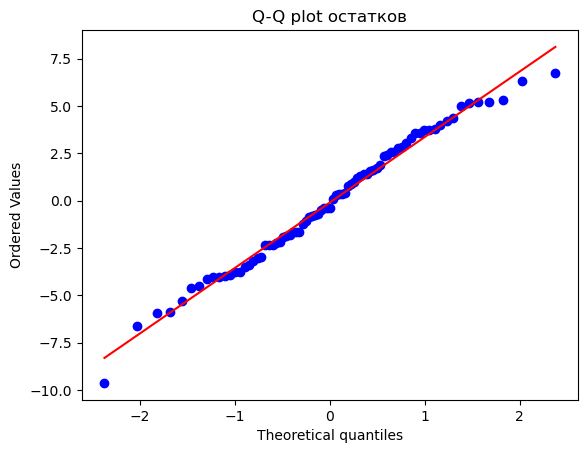

In [44]:
# Q-Q plot остатков
residuals = y_test - best_pred
stats.probplot(residuals, plot=plt)
plt.title('Q-Q plot остатков')
plt.show()

In [45]:
# Тест Шапиро-Уилка
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {shapiro_test.pvalue:.2f}")

Shapiro-Wilk test p-value: 0.57


<Axes: >

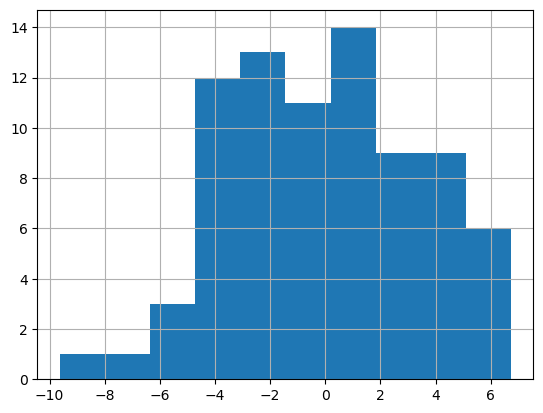

In [46]:
(y_test - best_pred).hist()

#### => Предпосылки линейной регрессии выполняются 

### **Лучшая модель для G2 - Ridge**:
- MAE = 2.83
- MSE = 11.50
- RMSE = 3.39
- R2 = 0.19
- Лучшие параметры: {'alpha': 10}

In [47]:
best_model_coef = pd.DataFrame({
    'feature': X_train.columns,
    'coef': best_model.coef_
})

important_features = best_model_coef[best_model_coef['coef'] != 0].sort_values(by="coef", ascending=False)
print("Коэффициенты")
print(important_features)

Коэффициенты
              feature      coef
33           paid_yes  0.518462
14              sex_M  0.496083
1                Medu  0.494811
36         higher_yes  0.467874
4           studytime  0.463501
16        famsize_LE3  0.333909
18        Mjob_health  0.311993
37       internet_yes  0.298116
20      Mjob_services  0.175510
2                Fedu  0.160456
28  reason_reputation  0.110185
7            freetime  0.058123
6              famrel  0.056524
15          address_U  0.050994
23         Fjob_other -0.000643
10               Walc -0.024670
9                Dalc -0.072767
3          traveltime -0.188983
11             health -0.214364
21       Mjob_teacher -0.231190
38       romantic_yes -0.245236
0                 age -0.298671
8               goout -0.463124
31      schoolsup_yes -0.642279
32         famsup_yes -0.716849


**Топ-3 позитивных фактора для G2:**
- Платное дополнительное образование (+0.52 балла)
- Мужской пол (+0.50)
- Образование матери (+0.49)


**Топ-3 негативных фактора**:
- Семейная поддержка (-0.72)
- Школьная помощь (-0.64)
- Активная соцжизнь (-0.46)

## Модель для G3

In [48]:
target = 'G3'

In [49]:
y = df[target]
y = pd.DataFrame({'G3': y})
y.head()

G3
0   6
1   6
2  10
3  15
4  10

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [51]:
X_train.nunique()

school         2
sex            2
age            8
address        2
famsize        2
Pstatus        2
Medu           5
Fedu           5
Mjob           5
Fjob           5
reason         4
guardian       3
traveltime     4
studytime      4
failures       4
schoolsup      2
famsup         2
paid           2
activities     2
nursery        2
higher         2
internet       2
romantic       2
famrel         5
freetime       5
goout          5
Dalc           5
Walc           5
health         5
absences      33
dtype: int64

In [52]:
preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_features),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='first'), cat_features),
        ]
    )
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
cat_encoder = preprocessor.named_transformers_["cat"]
cat_feature_names = cat_encoder.get_feature_names_out(cat_features)

all_feature_names = num_features + list(cat_feature_names)

X_train = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_test = pd.DataFrame(X_test_processed, columns=all_feature_names)
print(f'X_train shape: {X_train.shape}')

X_train shape: (316, 39)


In [53]:
for column in X_train[num_features].columns:
    if X_train[column].nunique() > 2:
        delete_outliers(X_train, column)

delete_outliers(y_train, target)

In [54]:
X_train, X_test = remove_high_vif_features(X_train, X_test, 8)
final_vif = calculate_vif(X_train)
final_vif['VIF'].max()
print(final_vif.sort_values('VIF', ascending=False))

              feature        VIF
0               const  81.726990
23         Fjob_other   5.482880
24      Fjob_services   4.851513
21       Mjob_teacher   3.097364
2                Medu   2.924852
20      Mjob_services   2.680528
19         Mjob_other   2.554941
10               Walc   2.531391
25       Fjob_teacher   2.487460
18        Mjob_health   2.344174
22        Fjob_health   2.153923
9                Dalc   2.104319
3                Fedu   2.039631
1                 age   1.782922
30     guardian_other   1.717095
8               goout   1.622245
14              sex_M   1.566688
28  reason_reputation   1.560977
29    guardian_mother   1.559009
5           studytime   1.456677
13          school_MS   1.439103
26        reason_home   1.438091
33           paid_yes   1.371127
27       reason_other   1.356275
7            freetime   1.340887
4          traveltime   1.337824
15          address_U   1.328389
12           absences   1.327436
32         famsup_yes   1.324721
36        

In [55]:
target_res = {}
y_train = y_train.squeeze()
y_test = y_test.squeeze()
for model, config in models.items():
    mse, mae, rmse, r2, best_params, best_model, y_pred = train_and_evaluate(config['model'], config['params'], X_train, X_test, y_train, y_test)
    target_res[model] = {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "Best_params": best_params,
        "Y_pred": y_pred
    }

In [56]:
print(f"\n=== Результаты для {target} ===")
for model_name, metrics in target_res.items():
    print(f"\n{model_name}:")
    print(f"  MAE = {metrics['MAE']:.2f}")
    print(f"  MSE = {metrics['MSE']:.2f}")
    print(f"  RMSE = {metrics['RMSE']:.2f}")
    print(f"  R2 = {metrics['R2']:.2f}")
    if metrics["Best_params"]:
        print(f"  Лучшие параметры: {metrics['Best_params']}")
    


=== Результаты для G3 ===

OLS:
  MAE = 3.59
  MSE = 18.69
  RMSE = 4.32
  R2 = 0.09

Ridge:
  MAE = 3.54
  MSE = 18.39
  RMSE = 4.29
  R2 = 0.10
  Лучшие параметры: {'alpha': 10}

Lasso:
  MAE = 3.56
  MSE = 19.16
  RMSE = 4.38
  R2 = 0.07
  Лучшие параметры: {'alpha': 0.1}

ElasticNet:
  MAE = 3.54
  MSE = 18.72
  RMSE = 4.33
  R2 = 0.09
  Лучшие параметры: {'alpha': 0.1, 'l1_ratio': 0.5}


In [57]:
best_pred = target_res['Ridge']['Y_pred']

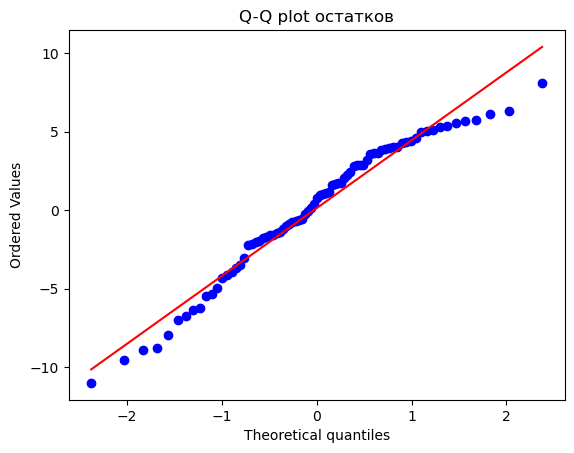

In [58]:
# Q-Q plot остатков
residuals = y_test - best_pred
stats.probplot(residuals, plot=plt)
plt.title('Q-Q plot остатков')
plt.show()

In [59]:
# Тест Шапиро-Уилка
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk test p-value:, {shapiro_test.pvalue:.2f}")

Shapiro-Wilk test p-value:, 0.02


<Axes: >

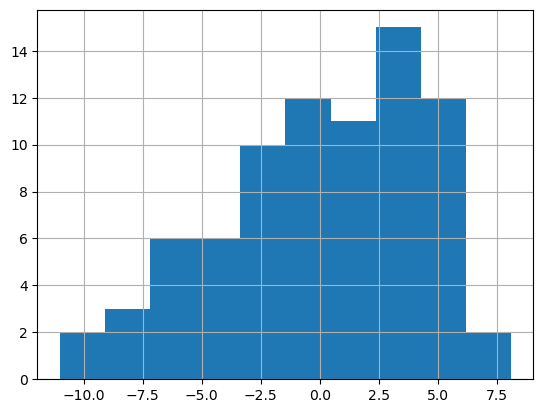

In [60]:
(y_test - best_pred).hist()

#### => Предпосылки линейной регрессии скорее не выполняются 

### **Лучшая модель для G3 - Ridge**:
- MAE = 3.54
- MSE = 18.39
- RMSE = 4.29
- R2 = 0.10
- Лучшие параметры: {'alpha': 10}

In [61]:
best_model_coef = pd.DataFrame({
    'feature': X_train.columns,
    'coef': best_model.coef_
})

important_features = best_model_coef[best_model_coef['coef'] != 0].sort_values(by="coef", ascending=False)
print("Коэффициенты")
print(important_features)

Коэффициенты
              feature      coef
14              sex_M  0.809777
36         higher_yes  0.787380
33           paid_yes  0.774585
12           absences  0.746273
1                Medu  0.608363
4           studytime  0.554749
16        famsize_LE3  0.469853
6              famrel  0.352518
18        Mjob_health  0.315181
37       internet_yes  0.162954
20      Mjob_services  0.158613
27       reason_other  0.102385
7            freetime  0.100164
2                Fedu  0.090591
28  reason_reputation  0.082843
15          address_U  0.071890
13          school_MS  0.061073
34     activities_yes -0.133555
21       Mjob_teacher -0.139567
17          Pstatus_T -0.170854
3          traveltime -0.178294
11             health -0.183088
26        reason_home -0.250819
9                Dalc -0.261402
31      schoolsup_yes -0.376013
8               goout -0.473679
0                 age -0.500977
32         famsup_yes -0.702479
38       romantic_yes -0.714523


**Топ-3 позитивных фактора для G3:**
- Мужской пол (+0.81)
- Планы на высшее образование (+0.79)
- Платное дополнительное образование (+0.77 балла)


**Топ-3 негативных фактора**:
- Налиие романтических отношений (-0.71)
- Семейная поддержка (-0.70)
- Возраст (-0.50)

### Общий вывод

#### Качество моделей:

- Все модели показывают скромную предсказательную силу (R2: 0.10-0.19)
- Наилучшее качество у модели для G2
- Худшее - для G3

#### Основные факторы влияния:
- Положительные:
    - Мужской пол (во всех моделях)
    - Образовательные амбиции (планы на вуз/доп.образование)

- Отрицательные:
    - Разные формы поддержки (семейная/школьная)
    - Социальная активность

### **Задача 2.**
Постройте модель для предсказания вероятности диабета у
человека на основе предоставленных признаков. Отберите из
предоставленных признаков только самые важные, основываясь на подборе
наиболее подходящей по метрике f1-score модели (максимальном качестве
по данной метрике).
Датасет для задачи: diabetes_classification.csv

**РЕШЕНИЕ**

**Выбранная модель**: логистическая регрессия, т.к. целевая переменная бинарная

In [62]:
df = pd.read_csv("diabetes_classification.csv")
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [63]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [64]:
df['Outcome'].unique()

array([1, 0])

In [65]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [67]:
df.nunique()

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

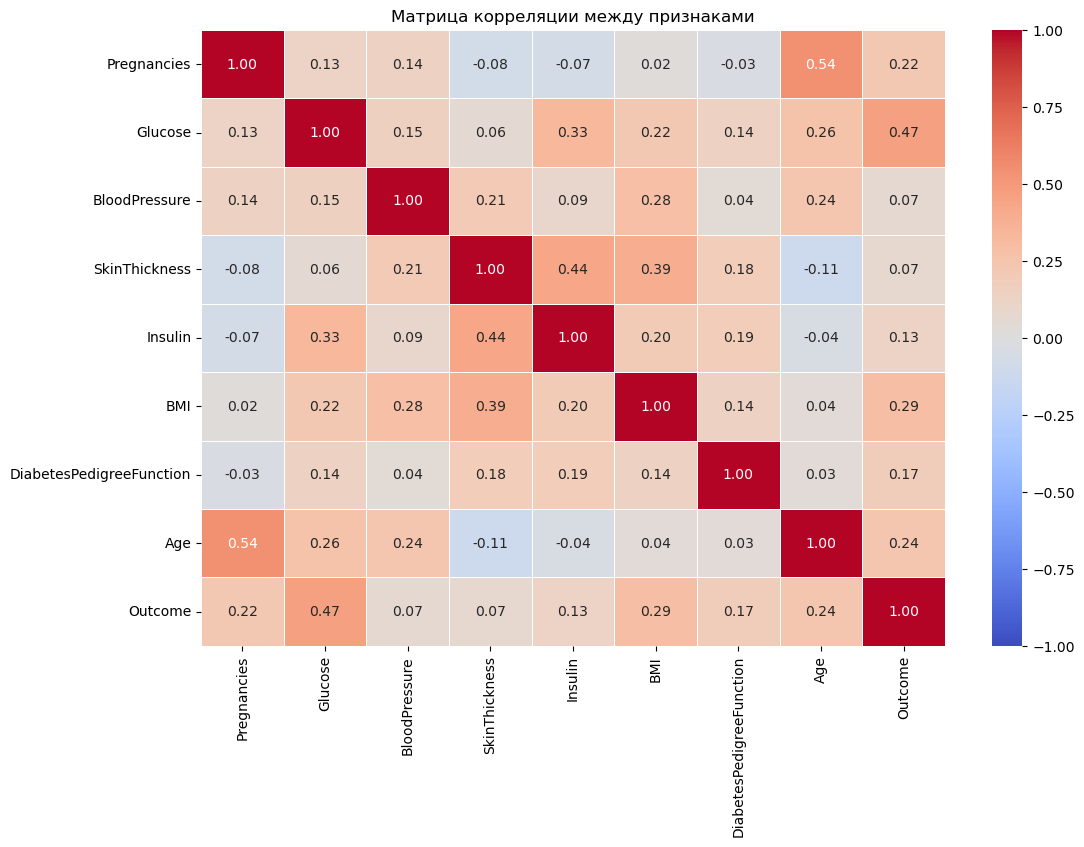

In [69]:
# Вычисляем матрицу корреляции
corr_matrix = df.corr()

# Визуализируем
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm',
            vmin=-1, 
            vmax=1,
            linewidths=0.5)
plt.title("Матрица корреляции между признаками")
plt.show()

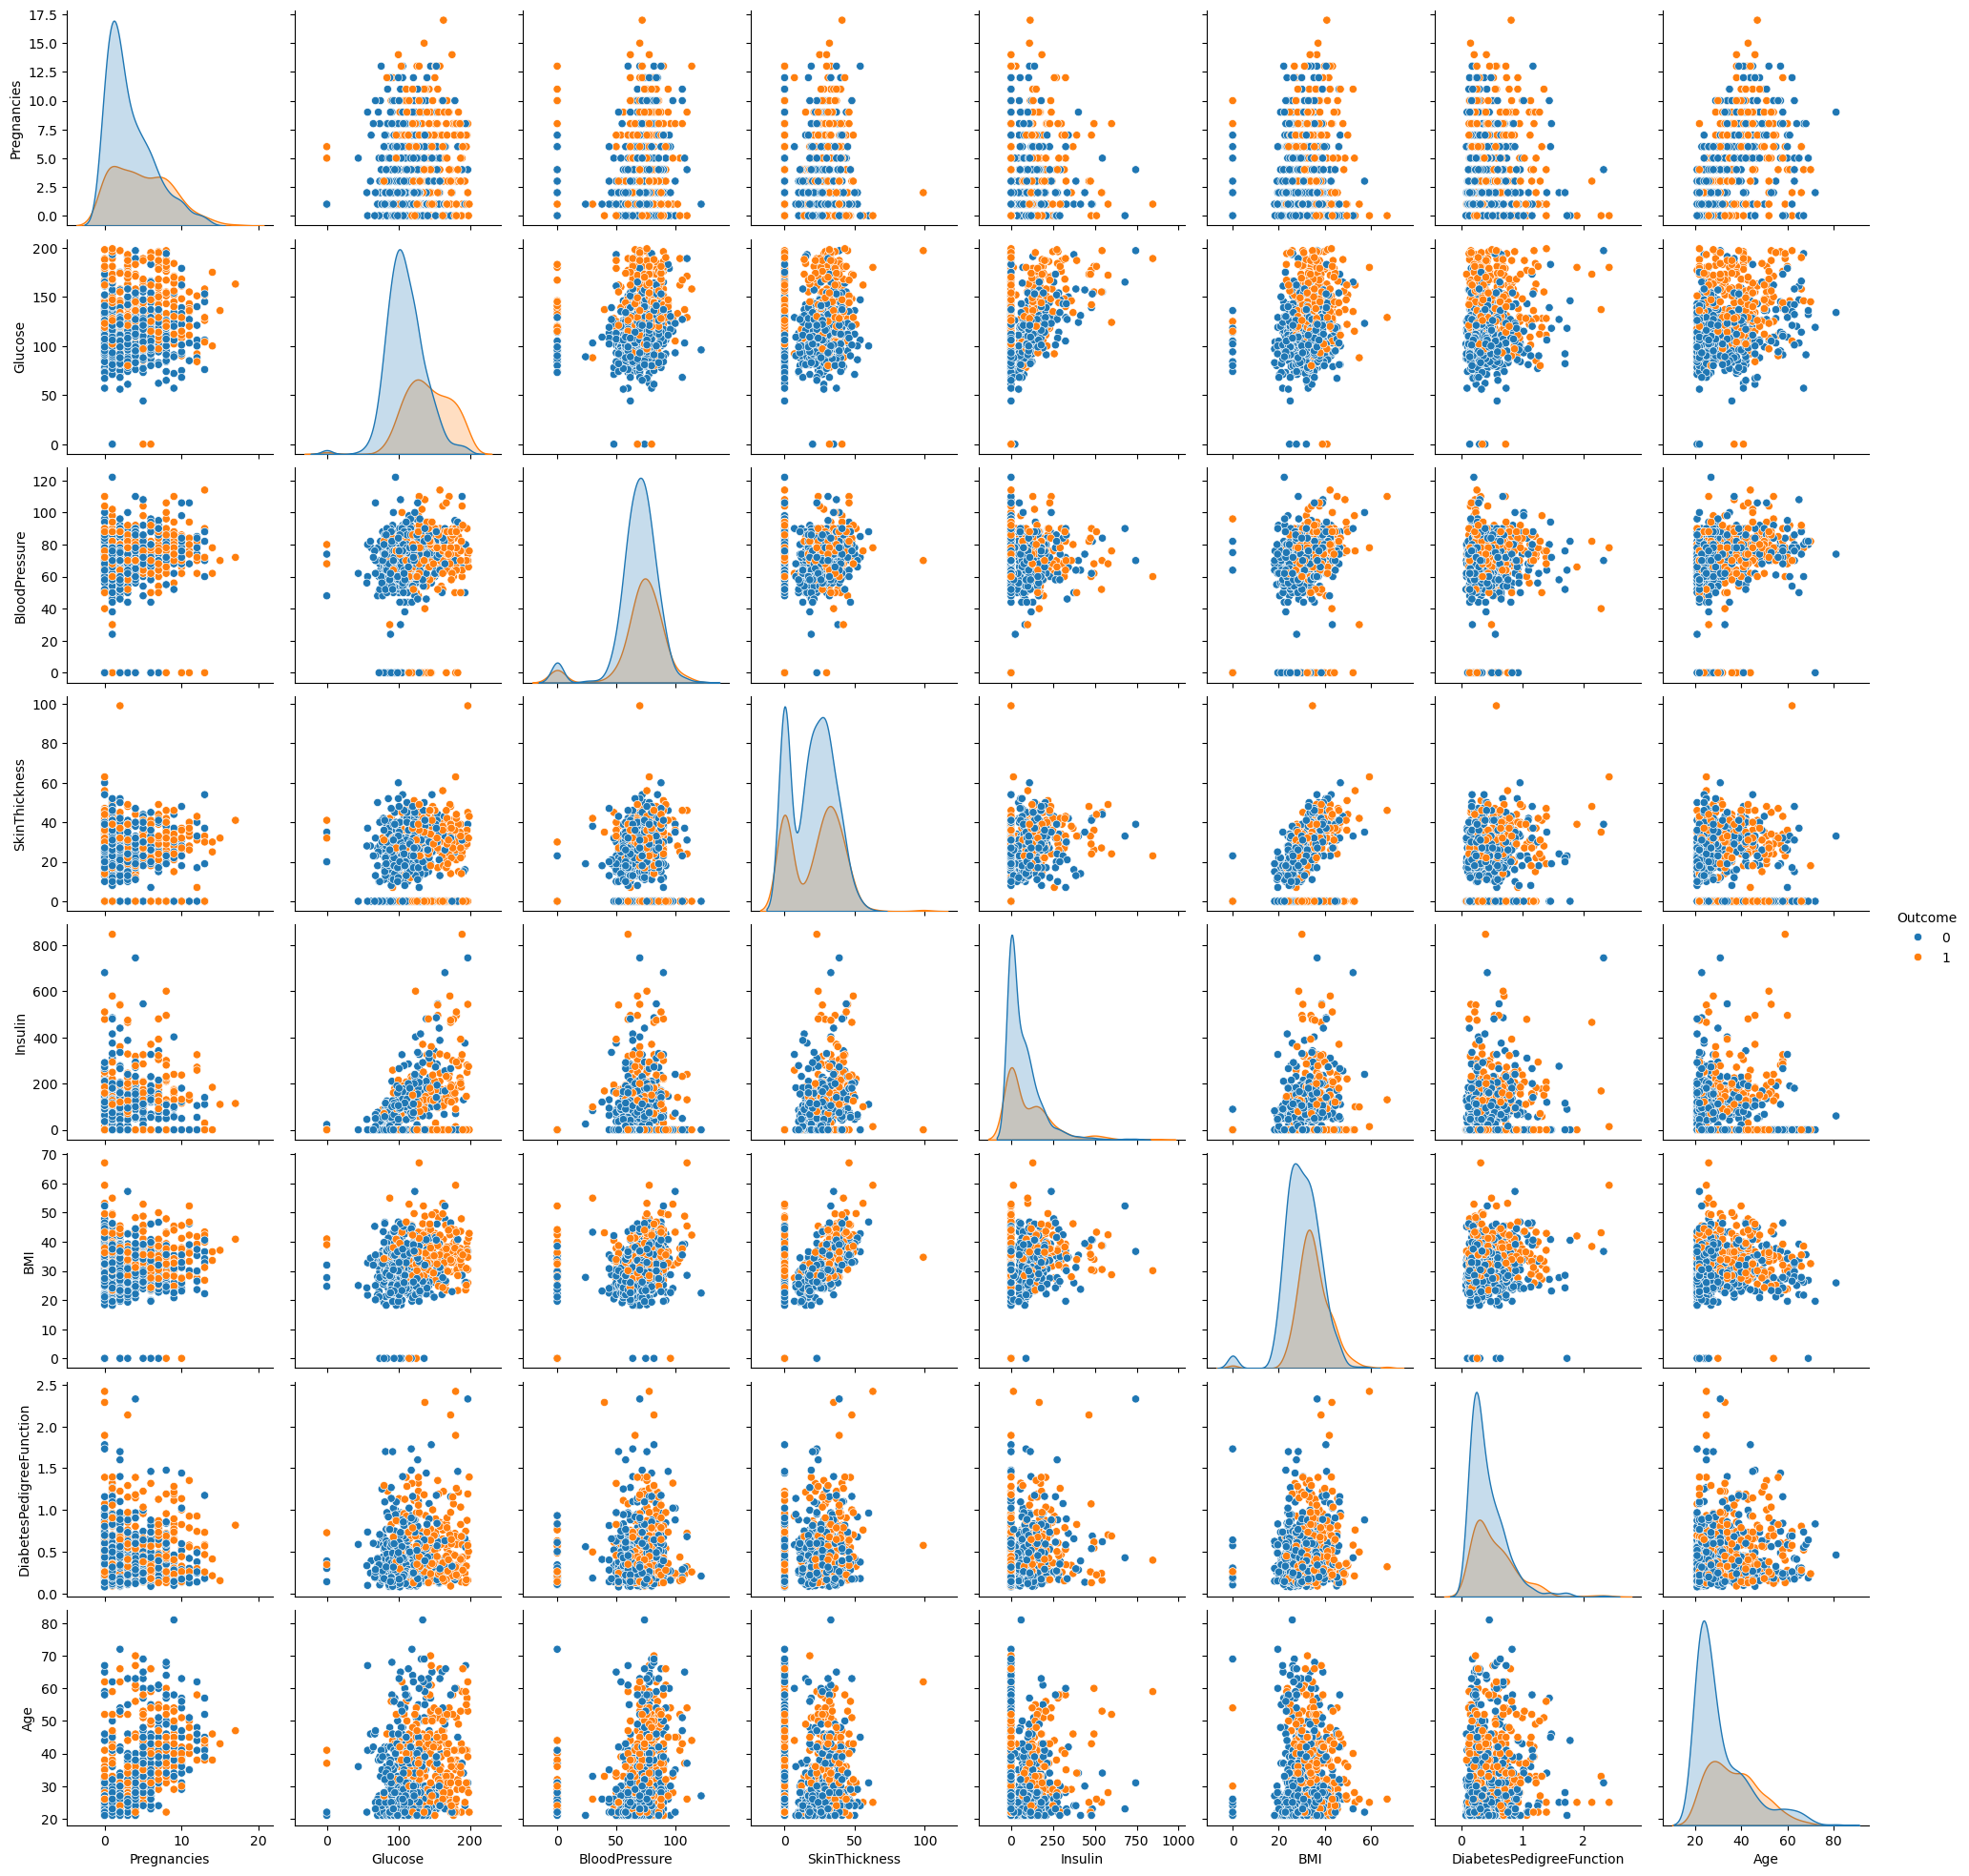

In [70]:
sns.pairplot(df, hue = "Outcome")

In [71]:
X = df.drop(columns=['Outcome'])
X.shape

(768, 8)

In [72]:
y = df['Outcome']

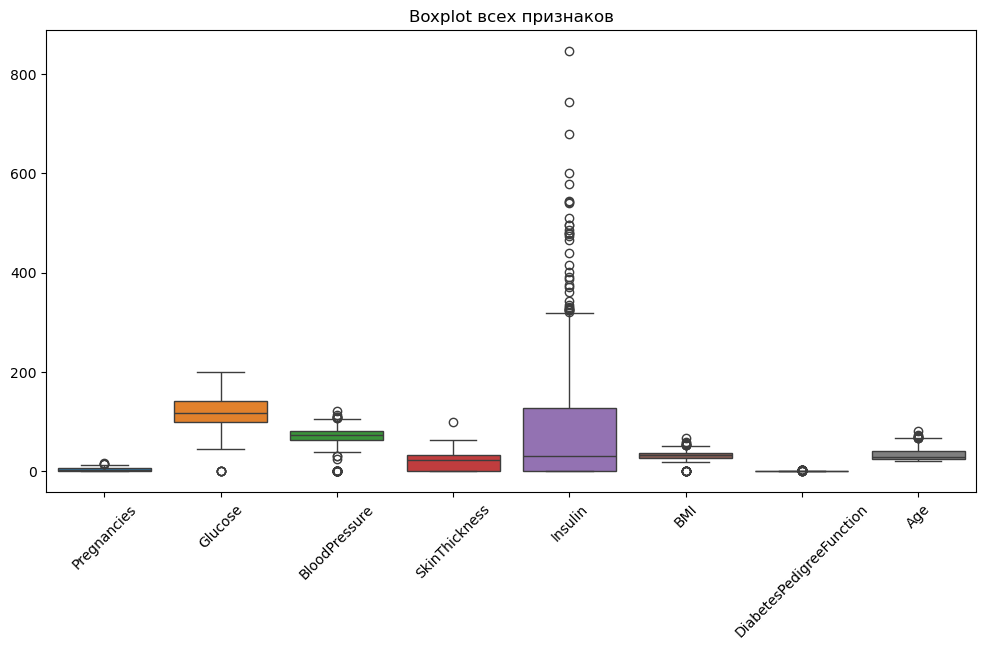

In [73]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.drop('Outcome', axis=1)) 
plt.xticks(rotation=45) 
plt.title('Boxplot всех признаков')
plt.show()

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(537, 8)
(231, 8)


In [75]:
# удаление выбросов
mask = pd.Series(True, index=df.index)

for column in X_train.columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    X_train[column] =  X_train[column].clip(lower_bound, upper_bound)

In [76]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [78]:
def calculate_vif(X):
    X_const = add_constant(X)
    vif = pd.DataFrame()
    vif['feature'] = X_const.columns
    vif['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
    return vif

In [79]:
def remove_high_vif_features(X_train, X_test, threshold=10):
    X_train_clean = X_train.copy()
    X_test_clean = X_test.copy()
    
    while True:
        vif_res = calculate_vif(X_train_clean) 
        vif_res = vif_res[vif_res['feature'] != 'const']
        if vif_res.empty or vif_res['VIF'].max() < threshold:
            break
        worst_feature = vif_res.loc[vif_res['VIF'].idxmax(), 'feature']
        X_train_clean = X_train_clean.drop(columns=[worst_feature])
        X_test_clean = X_test_clean.drop(columns=[worst_feature])
    return X_train_clean, X_test_clean

X_train, X_test = remove_high_vif_features(X_train_scaled, X_test_scaled)

In [81]:
vif_res_final = calculate_vif(X_train) 
vif_res_final = vif_res_final[vif_res_final['feature'] != 'const']
print(vif_res_final.sort_values('VIF', ascending=False))
X_train.shape

                    feature       VIF
8                       Age  1.681152
4             SkinThickness  1.602931
5                   Insulin  1.523539
1               Pregnancies  1.447152
2                   Glucose  1.355774
6                       BMI  1.314538
3             BloodPressure  1.217445
7  DiabetesPedigreeFunction  1.059451


(537, 8)

In [82]:
model = LogisticRegression(solver='liblinear', random_state=42)

params = {
    "C": [0.001, 0.01, 0.1, 0.5, 1.0, 3, 5, 10],
    "penalty": ["l1", "l2"],
    "class_weight": [None, "balanced"]
}

cv_strategy = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
model_selector = GridSearchCV(
    estimator=model, 
    param_grid=params, 
    scoring='f1', 
    cv=cv_strategy, 
    n_jobs=-1
)
model_selector.fit(X_train, y_train)
best_model = model_selector.best_estimator_

In [83]:
model_selector.best_score_

0.6822766989938086

In [95]:
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f"F1 score = {f1:.2f}")

F1 score = 0.62


#### Лучшая модель имеет параметры:

In [96]:
model_selector.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}

In [97]:
model_selector.best_estimator_.coef_

array([[ 0.18493856,  0.98909389, -0.10669489, -0.02921577, -0.08687125,
         0.69915964,  0.19794537,  0.41658722]])

In [98]:
best_model_coef = pd.DataFrame({
    'feature': X_train.columns,
    'coef': best_model.coef_.flatten()
})

important_features = best_model_coef[np.abs(best_model_coef['coef']) != 0].sort_values(by="coef", ascending=False)
print("Отобранные коэффициенты")
print(important_features)
print(f"Были обнулены: {best_model_coef[np.abs(best_model_coef['coef']) != 0].shape[0]} признаков")

Отобранные коэффициенты
                    feature      coef
1                   Glucose  0.989094
5                       BMI  0.699160
7                       Age  0.416587
6  DiabetesPedigreeFunction  0.197945
0               Pregnancies  0.184939
3             SkinThickness -0.029216
4                   Insulin -0.086871
2             BloodPressure -0.106695
Были обнулены: 8 признаков


### Выводы:  

**Топ-3 позитивных фактора**:
- Glucose: чем выше уровень глюкозы, тем выше вероятность диабета
- BMI: повышенный индекс массы тела увеличивает риск диабета
- Age: с возрастом вероятность диабета возрастает

**Топ-3 негативных фактора**:
- BloodPressure: кровяное давление может быть связано с меньшим риском
- Insulin: более высокий уровень инсулина снижает вероятность диабета
- SkinThickness: меньшая толщина кожи коррелирует с пониженным риском

### **Задача 3.**
Постройте модель предсказания количества претензий за период
эксплуатации (ClaimNB) двигателя на основе его признаков. Отберите только
самые важные для предсказания признаки на основе результатов модели и
проанализируйте результат.
Датасет для задачи: freMTPL2freq.csv

**РЕШЕНИЕ**

**Выбранная модель**: Пуассоновская регрессия, т.к. целевая переменная — это счетчик (количество претензий), и он неотрицательный

In [99]:
df = pd.read_csv("freMTPL2freq.csv")
df.head()

IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  \
0    1.0        1      0.10    D         5       0       55          50   
1    3.0        1      0.77    D         5       0       55          50   
2    5.0        1      0.75    B         6       2       52          50   
3   10.0        1      0.09    B         7       0       46          50   
4   11.0        1      0.84    B         7       0       46          50   

  VehBrand   VehGas  Density Region  
0      B12  Regular     1217    R82  
1      B12  Regular     1217    R82  
2      B12   Diesel       54    R22  
3      B12   Diesel       76    R72  
4      B12   Diesel       76    R72

In [100]:
df.describe()

IDpol        ClaimNb       Exposure       VehPower  \
count  6.780130e+05  678013.000000  678013.000000  678013.000000   
mean   2.621857e+06       0.053247       0.528750       6.454631   
std    1.641783e+06       0.240117       0.364442       2.050906   
min    1.000000e+00       0.000000       0.002732       4.000000   
25%    1.157951e+06       0.000000       0.180000       5.000000   
50%    2.272152e+06       0.000000       0.490000       6.000000   
75%    4.046274e+06       0.000000       0.990000       7.000000   
max    6.114330e+06      16.000000       2.010000      15.000000   

              VehAge        DrivAge     BonusMalus        Density  
count  678013.000000  678013.000000  678013.000000  678013.000000  
mean        7.044265      45.499122      59.761502    1792.422405  
std         5.666232      14.137444      15.636658    3958.646564  
min         0.000000      18.000000      50.000000       1.000000  
25%         2.000000      34.000000      50.000000      92.000000  
50%         6.000000      44.000000      50.000000     393.000000  
75%        11.000000      55.000000      64.000000    1658.000000  
max       100.000000     100.000000     230.000000   27000.000000

In [101]:
df['ClaimNb'].unique()

array([ 1,  2,  4,  3, 11,  0,  5,  6,  8, 16,  9])

In [102]:
df['ClaimNb'].value_counts()

ClaimNb
0     643953
1      32178
2       1784
3         82
4          7
11         3
5          2
6          1
8          1
16         1
9          1
Name: count, dtype: int64

#### => большой дисбаланс классов

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  int64  
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  int64  
 5   VehAge      678013 non-null  int64  
 6   DrivAge     678013 non-null  int64  
 7   BonusMalus  678013 non-null  int64  
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  int64  
 11  Region      678013 non-null  object 
dtypes: float64(2), int64(6), object(4)
memory usage: 62.1+ MB


In [104]:
df.nunique()

IDpol         678013
ClaimNb           11
Exposure         187
Area               6
VehPower          12
VehAge            78
DrivAge           83
BonusMalus       115
VehBrand          11
VehGas             2
Density         1607
Region            22
dtype: int64

In [105]:
df = df.drop('IDpol', axis=1)

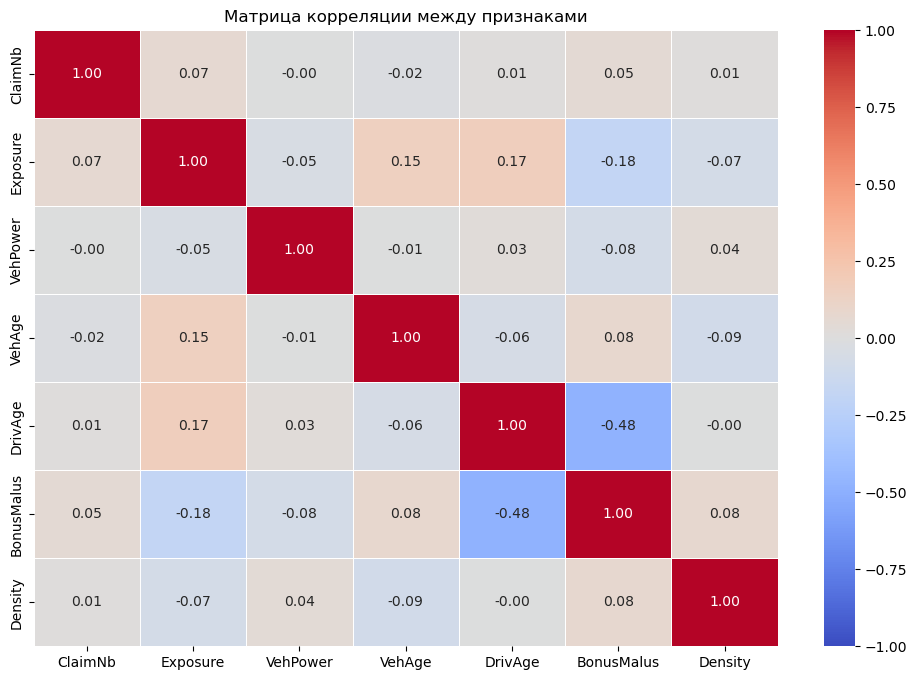

In [106]:
# Вычисляем матрицу корреляции
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numeric_cols].corr()

# Визуализируем
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm',
            vmin=-1, 
            vmax=1,
            linewidths=0.5)
plt.title("Матрица корреляции между признаками")
plt.show()

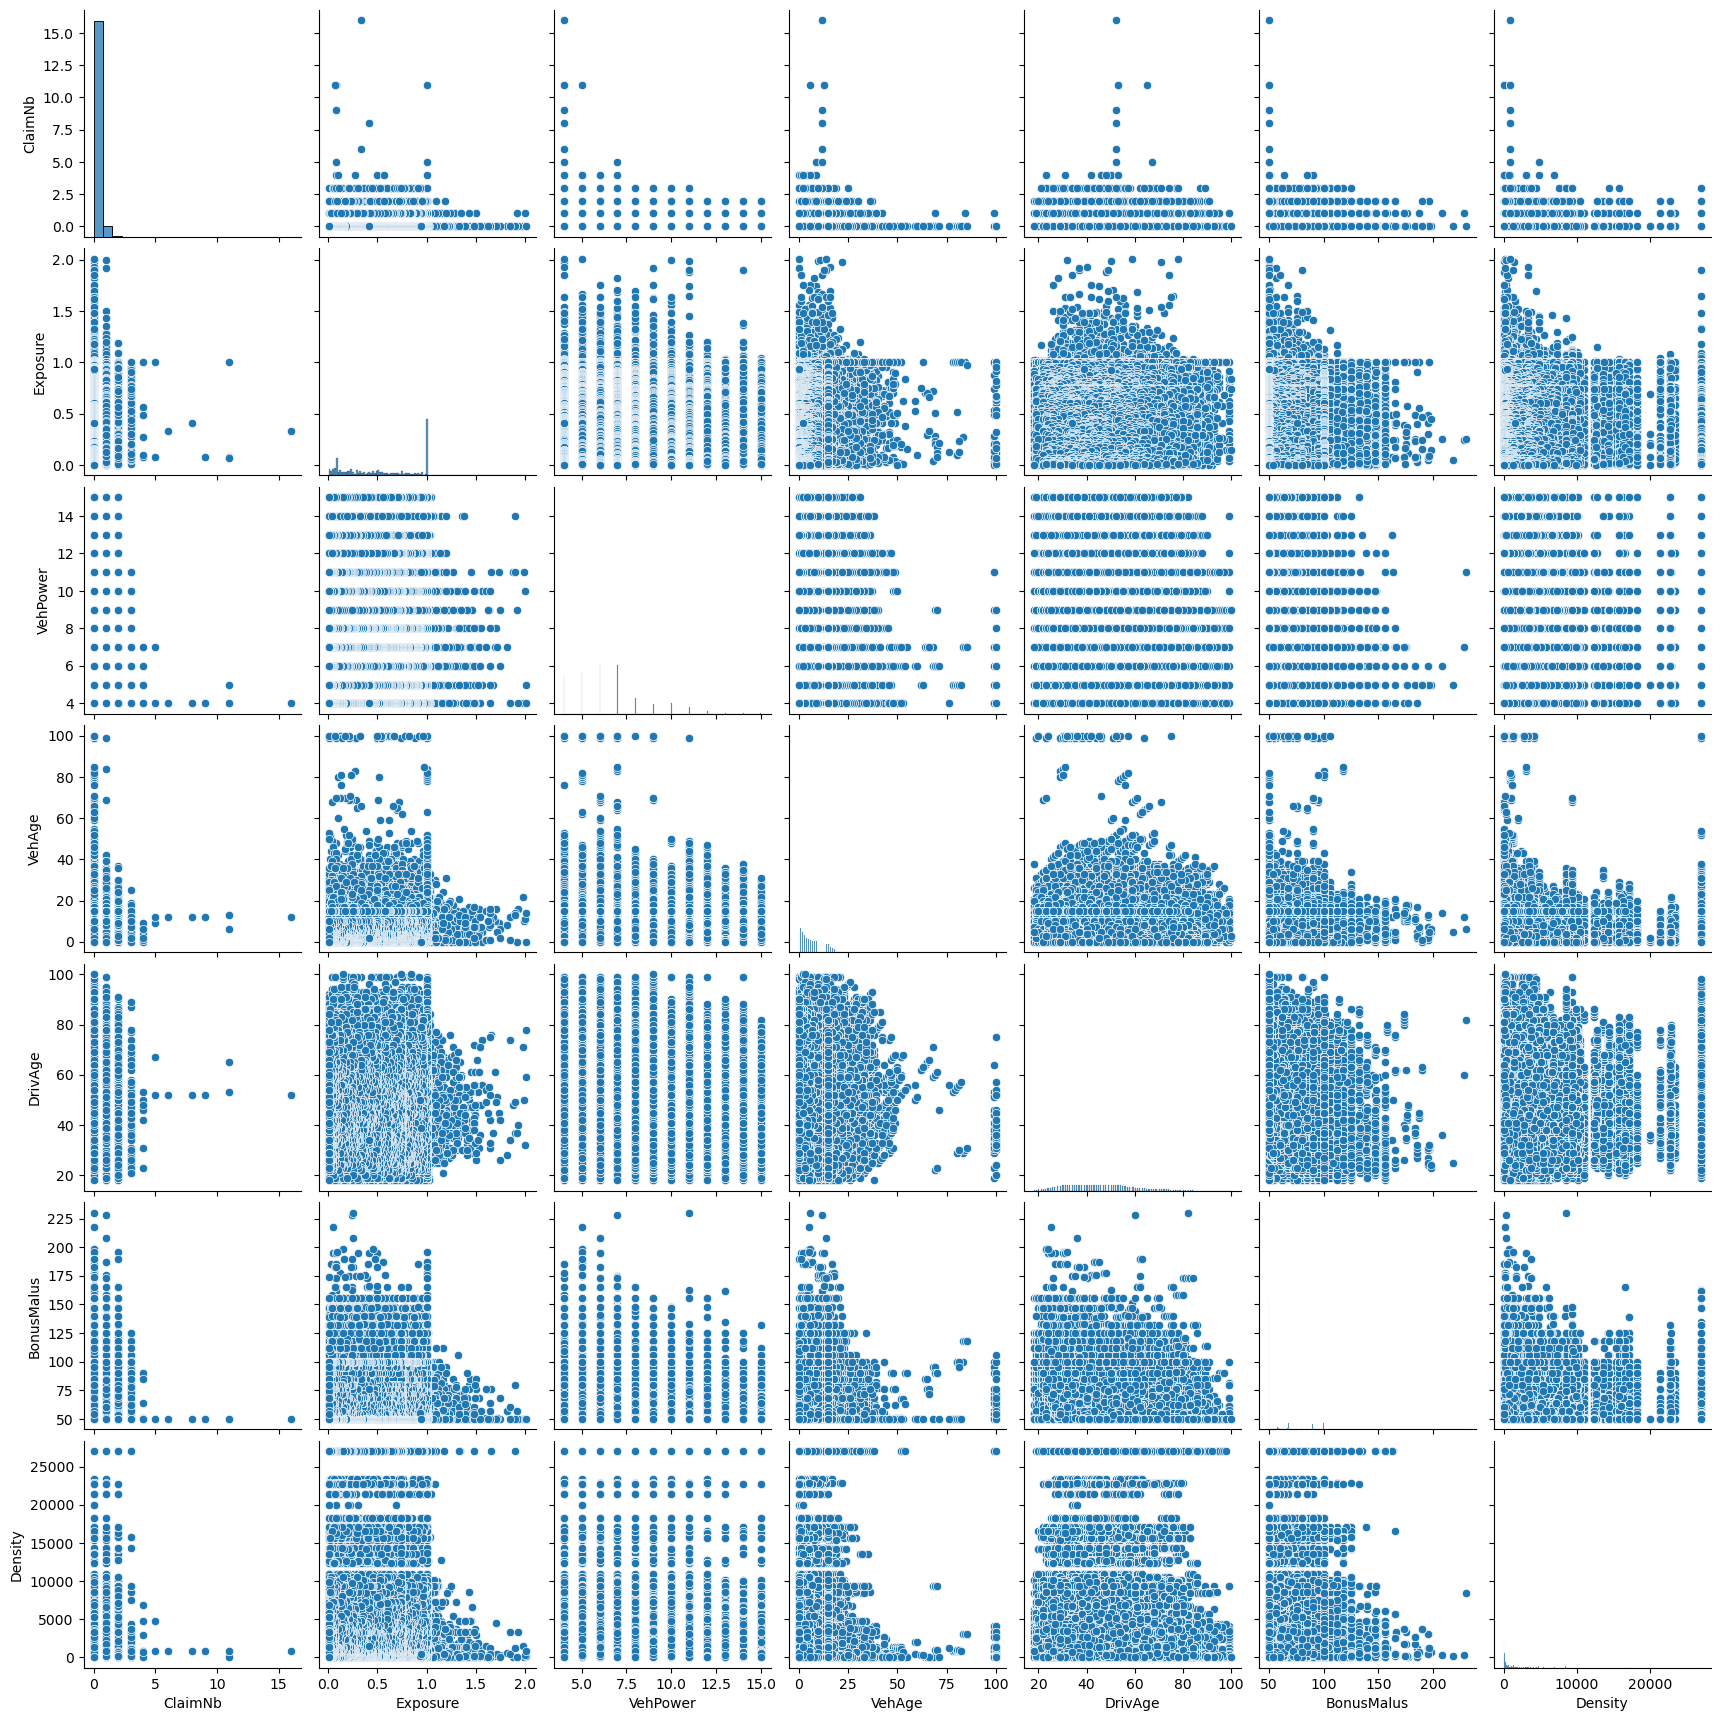

In [107]:
sns.pairplot(df)

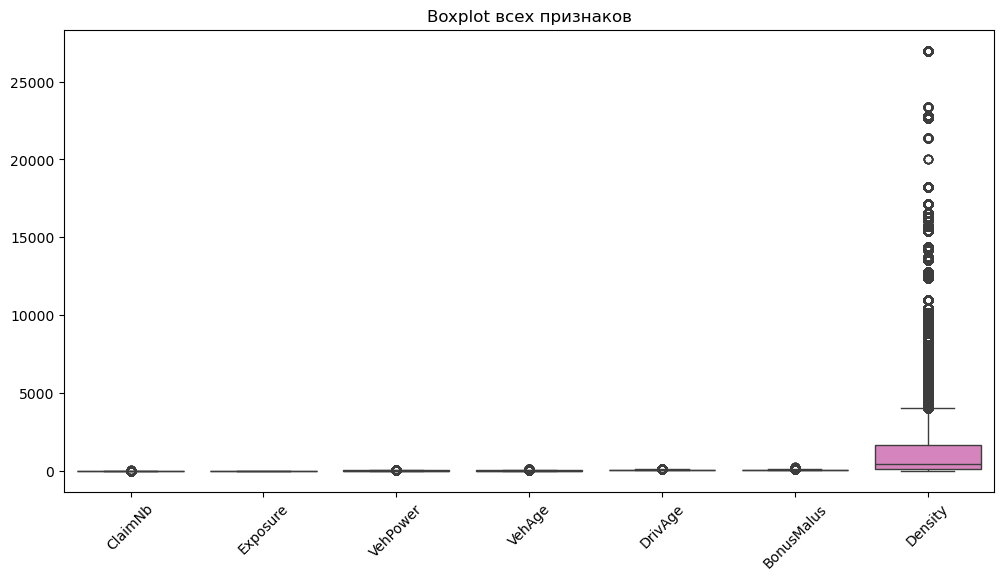

In [108]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df) 
plt.xticks(rotation=45) 
plt.title('Boxplot всех признаков')
plt.show()

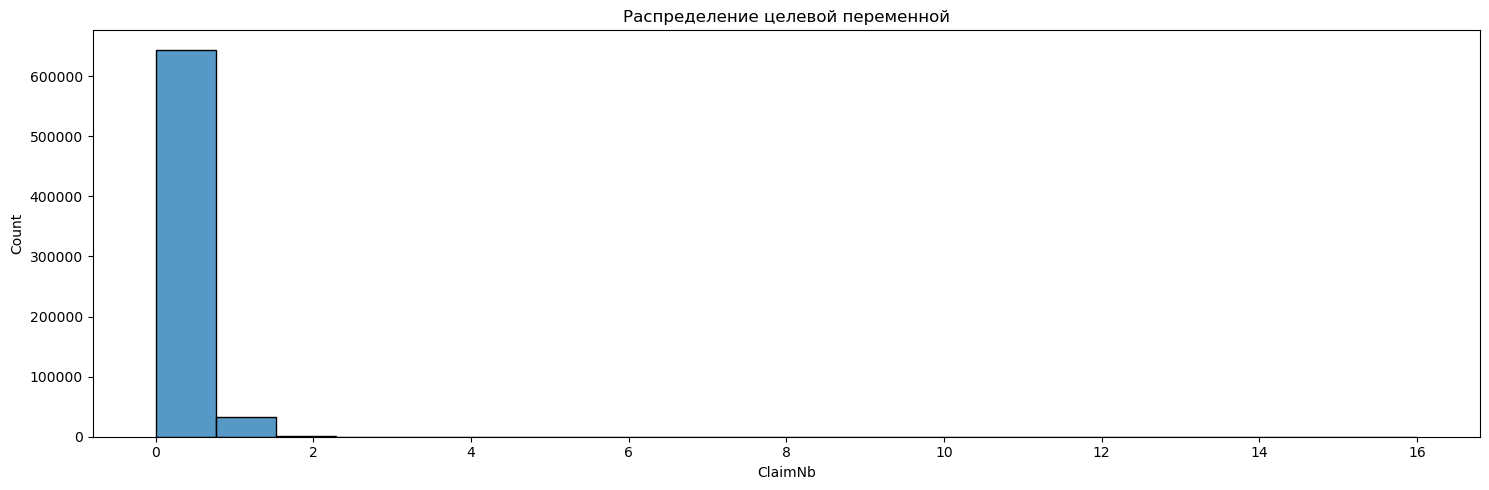

In [109]:
plt.figure(figsize=(15, 5))
sns.histplot(df['ClaimNb'], kde=False)
plt.title(f'Распределение целевой переменной')
plt.tight_layout()
plt.show()

In [ ]:
# Проверка дисперсии и среднего
y = df['ClaimNb']
print(f"Среднее = {y.mean():.2f}")
print(f"Дисперсия = {y.var():.2f}")
print(f"Отношение дисперсии к среднему = {y.var() / y.mean():.2f}")

#### Дисперсия и среднее примерно равны => предпосылки для применения пуассоновской регрессии выполняются

In [110]:
cat_features = ['Area',	'VehBrand',	'VehGas',	'Region']
num_features = ['Exposure', 'VehPower', 'Density', 'VehAge', 'DrivAge', 'BonusMalus']

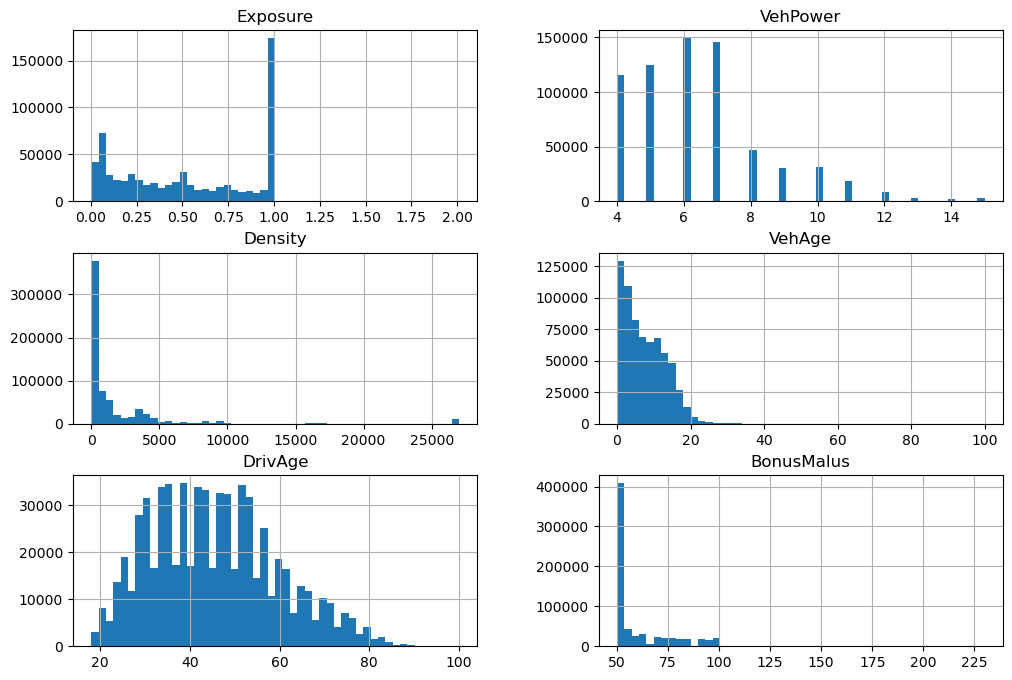

In [111]:
df[num_features].hist(bins=50, figsize=(12, 8))
plt.show()

In [112]:
X = df.drop(columns=['ClaimNb'])
X.shape

(678013, 10)

In [113]:
y = df['ClaimNb']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='first'), cat_features),
    ]
)

In [116]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [117]:
cat_encoder = preprocessor.named_transformers_["cat"]
cat_feature_names = cat_encoder.get_feature_names_out(cat_features)

all_feature_names = num_features + list(cat_feature_names)

X_train = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_test = pd.DataFrame(X_test_processed, columns=all_feature_names)

X_train.head()

Exposure  VehPower   Density    VehAge   DrivAge  BonusMalus  Area_B  \
0  1.292783 -0.221320 -0.427786 -0.361026  0.955064   -0.623996     1.0   
1  1.292783  1.731487 -0.424001  0.699694  1.096534   -0.623996     0.0   
2  1.292783  0.266882 -0.447218 -0.537813 -0.247429   -0.623996     0.0   
3  1.292783 -0.221320 -0.447976 -0.537813  0.459920   -0.623996     0.0   
4 -0.682983 -0.709522 -0.316241 -0.714600  1.803883   -0.623996     0.0   

   Area_C  Area_D  Area_E  ...  Region_R53  Region_R54  Region_R72  \
0     0.0     0.0     0.0  ...         0.0         0.0         1.0   
1     1.0     0.0     0.0  ...         0.0         0.0         0.0   
2     0.0     0.0     0.0  ...         0.0         0.0         1.0   
3     0.0     0.0     0.0  ...         0.0         0.0         0.0   
4     0.0     1.0     0.0  ...         1.0         0.0         0.0   

   Region_R73  Region_R74  Region_R82  Region_R83  Region_R91  Region_R93  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         1.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         1.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   Region_R94  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  

[5 rows x 43 columns]

In [118]:
# удаление выбросов
mask = pd.Series(True, index=df.index)

def delete_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    data[column] =  data[column].clip(lower_bound, upper_bound)

In [119]:
for column in X_train[num_features].columns:
    if X_train[column].nunique() > 2:
        delete_outliers(X_train, column)

In [134]:
# надо делать взвешивание из-за дисбаланса классов
model = PoissonRegressor()
params  = {'alpha': [0.01, 0.1, 1, 10], 'max_iter': [500, 800, 1000]}

sample_weight = np.where(y_train > 0, 10, 1)  

cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
        estimator=model, 
        param_grid=params, 
        scoring='neg_mean_poisson_deviance',
        cv=cv_strategy, 
        n_jobs=-1
    )
grid_search.fit(X_train, y_train, sample_weight=sample_weight)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
poisson_dev = mean_poisson_deviance(y_test, y_pred)

In [142]:
print(f'MSE = {mse:.2f}')
print(f'MAE = {mae:.2f}')
print(f'Poisson deviance = {poisson_dev:.2f}')
print(f"Лучшие параметры: {grid_search.best_params_}")

MSE = 0.16
MAE = 0.38
Poisson deviance = 0.73
Лучшие параметры: {'alpha': 0.01, 'max_iter': 500}


In [145]:
best_model_coef = pd.DataFrame({
    'feature': X_train.columns,
    'coef': best_model.coef_
})

important_features = best_model_coef[np.abs(best_model_coef['coef']) >= 0.06].sort_values(by="coef", ascending=False)
print("Выбранные коэффициенты:")
print(important_features)

Выбранные коэффициенты:
       feature      coef
0     Exposure  0.253680
5   BonusMalus  0.234470
33  Region_R53  0.083241
4      DrivAge  0.075925
25  Region_R24  0.069858
2      Density  0.066756
38  Region_R82  0.062525
35  Region_R72 -0.069869
3       VehAge -0.127314


#### Вывод:

**Топ-3 позитивных фактора**:
- Exposure: чем дольше срок страхования, тем больше вероятность претензий
- BonusMalus: клиенты с плохой историей (высокий бонус-малус) чаще подают претензии
- Region_R53: специфический регион с повышенным риском

**Топ-3 негативных фактора**:
- VehAge: новые автомобили чаще попадают в аварии
- Region_R72: регион с пониженным риском
- Region_R82: регион с пониженным риском